In [71]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt


import string 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

from tensorflow.keras.utils import plot_model

from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import accuracy_score

# Problem Statement

This is a binary text classification problem. The goal is to be able to classify tweets as either relating to a disaster or not. The training data consists of tweet texts, along with locations and keywords. I will first inspect the data, then clean it. Finally, I will train various different LSTM classification models and then compare their results.

This problem is an instance of natural language processing (NLP), where the goal is to use artificial intelligence to understand human language, in this case written language. Text classification is only one of many applications of NLP; others include machine translation, sentiment analysis, and chatbots / virtual assistants. All NLP applications share similarities with machine learning in general, but also use some characteristic techniques like tokenization and syntactic parsing.

# EDA

### Data Inspection

In [72]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [73]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [74]:
train_data.shape

(7613, 5)

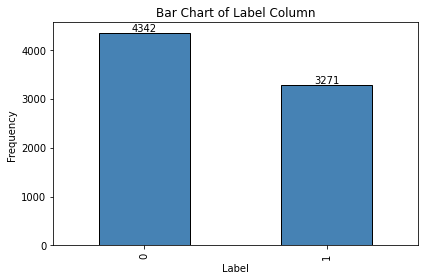

In [75]:
label_counts = train_data['target'].value_counts()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the bar chart
label_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')

# Set the title and axis labels
ax.set_title('Bar Chart of Label Column')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')

# Add value labels on top of each bar
for i, v in enumerate(label_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

fig.tight_layout()
plt.show()

In [76]:
data = train_data

# Check for null values
empty_columns = data.columns[data.isnull().all()]
print("Empty columns:", empty_columns)
print(data.isnull().sum(), '\n')

Empty columns: Index([], dtype='object')
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 



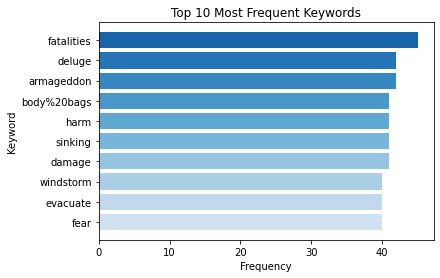

In [77]:
# Select the top 10 most frequent values
value_counts = train_data['keyword'].value_counts()
top_10_values = value_counts.head(10)
cmap = plt.get_cmap('Blues')

# Plot a horizontal bar chart
plt.barh(top_10_values.index[::-1], top_10_values.values[::-1], color=cmap(np.linspace(0.2, 0.8, len(top_10_values))))
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.title('Top 10 Most Frequent Keywords')
plt.show()

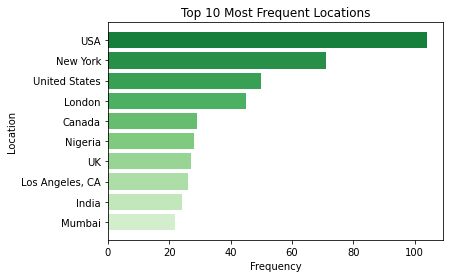

In [78]:
# Select the top 10 most frequent values
value_counts = train_data['location'].value_counts()
sorted_values = value_counts.sort_values(ascending=False)
top_10_values = sorted_values.head(10)
cmap = plt.get_cmap('Greens')

# Plot a horizontal bar chart
plt.barh(top_10_values.index[::-1], top_10_values.values[::-1], color=cmap(np.linspace(0.2, 0.8, len(top_10_values))))
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.title('Top 10 Most Frequent Locations')
plt.show()

In [79]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<AxesSubplot:xlabel='length', ylabel='Count'>

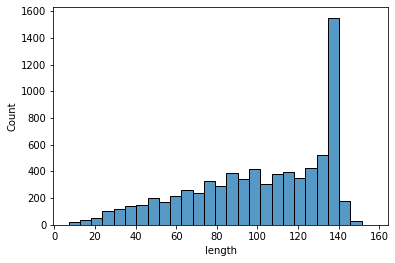

In [80]:
sns.histplot(train_data['length'])

### Data Cleanup

In [81]:
def clean_text(text):

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [82]:
train_data['clean_text'] = train_data['text'].apply(clean_text)

In [83]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [84]:
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

In [85]:
train_data["clean_text"] = train_data["clean_text"].apply(replace_abbrev)

In [86]:
train_data.head()

,id,keyword,location,text,target,length,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,Deeds Reason earthquake May ALLAH Forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfires evacuation orders Cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo Ruby Alaska smoke wildfires pou...


In [87]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
X = tokenizer.texts_to_sequences(train_data['clean_text'].values)
X = pad_sequences(X)

# Modeling - LSTM

I will be using an long short-term memory (LSTM) architecture for this problem. LSTM is a form of recurrent neural network (RNN) that can also capture long-term features of a data set. It is well suited to text classification because it can handle sequential input and capture broader contextual information due to its longer term memory, which gives it an advantage over architectures like multilayer perceptrons, which have no such memory.

In [88]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)
history_list = []
pred_list = []

In [89]:
def create_model(X, embed_dim=32, lstm_out=32, dropout=.02, recurrent_dropout=.04, activation='sigmoid', learning_rate=.002):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
    model.add(Dropout(dropout))
    model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(1,activation=activation))
    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
    print(model.summary())
    
    return model

In [90]:
model1 = create_model(X)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 19, 32)            96000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
history1 = model1.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
history_list.append(history1)
pred_list.append(model1.predict(X_test).round())

Epoch 1/10
191/191 [==============================] - 18s 83ms/step - loss: 0.6011 - accuracy: 0.6591 - val_loss: 0.4325 - val_accuracy: 0.8135
Epoch 2/10
191/191 [==============================] - 16s 81ms/step - loss: 0.3596 - accuracy: 0.8552 - val_loss: 0.4388 - val_accuracy: 0.8050
Epoch 3/10
191/191 [==============================] - 15s 80ms/step - loss: 0.2942 - accuracy: 0.8848 - val_loss: 0.4705 - val_accuracy: 0.7965
Epoch 4/10
191/191 [==============================] - 16s 84ms/step - loss: 0.2615 - accuracy: 0.8980 - val_loss: 0.5409 - val_accuracy: 0.7846
Epoch 5/10
191/191 [==============================] - 15s 79ms/step - loss: 0.2068 - accuracy: 0.9216 - val_loss: 0.5986 - val_accuracy: 0.7781
Epoch 6/10
191/191 [==============================] - 16s 84ms/step - loss: 0.1749 - accuracy: 0.9346 - val_loss: 0.7022 - val_accuracy: 0.7643
Epoch 7/10
191/191 [==============================] - 15s 80ms/step - loss: 0.1292 - accuracy: 0.9519 - val_loss: 0.7906 - val_accuracy:

In [92]:
model2 = create_model(X,embed_dim = 64)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 19, 64)            192000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 204,449
Trainable params: 204,449
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
history2 = model2.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
history_list.append(history2)
pred_list.append(model2.predict(X_test).round())

Epoch 1/10
191/191 [==============================] - 19s 87ms/step - loss: 0.5943 - accuracy: 0.6687 - val_loss: 0.4302 - val_accuracy: 0.8129
Epoch 2/10
191/191 [==============================] - 15s 81ms/step - loss: 0.3490 - accuracy: 0.8555 - val_loss: 0.4464 - val_accuracy: 0.8083
Epoch 3/10
191/191 [==============================] - 16s 86ms/step - loss: 0.2887 - accuracy: 0.8885 - val_loss: 0.4800 - val_accuracy: 0.7958
Epoch 4/10
191/191 [==============================] - 16s 82ms/step - loss: 0.2301 - accuracy: 0.9137 - val_loss: 0.5874 - val_accuracy: 0.7735
Epoch 5/10
191/191 [==============================] - 17s 87ms/step - loss: 0.1709 - accuracy: 0.9359 - val_loss: 0.6597 - val_accuracy: 0.7643
Epoch 6/10
191/191 [==============================] - 16s 81ms/step - loss: 0.1375 - accuracy: 0.9447 - val_loss: 0.7605 - val_accuracy: 0.7577
Epoch 7/10
191/191 [==============================] - 16s 86ms/step - loss: 0.1121 - accuracy: 0.9546 - val_loss: 0.9200 - val_accuracy:

In [94]:
model3 = create_model(X,dropout=.03)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 19, 32)            96000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
history3 = model3.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
history_list.append(history3)
pred_list.append(model3.predict(X_test).round())

Epoch 1/10
191/191 [==============================] - 18s 84ms/step - loss: 0.6226 - accuracy: 0.6424 - val_loss: 0.4259 - val_accuracy: 0.8188
Epoch 2/10
191/191 [==============================] - 15s 80ms/step - loss: 0.3572 - accuracy: 0.8532 - val_loss: 0.4366 - val_accuracy: 0.8148
Epoch 3/10
191/191 [==============================] - 16s 83ms/step - loss: 0.2814 - accuracy: 0.8904 - val_loss: 0.4689 - val_accuracy: 0.7965
Epoch 4/10
191/191 [==============================] - 15s 79ms/step - loss: 0.2488 - accuracy: 0.9026 - val_loss: 0.5401 - val_accuracy: 0.7768
Epoch 5/10
191/191 [==============================] - 16s 82ms/step - loss: 0.1994 - accuracy: 0.9205 - val_loss: 0.5648 - val_accuracy: 0.7708
Epoch 6/10
191/191 [==============================] - 15s 79ms/step - loss: 0.1780 - accuracy: 0.9307 - val_loss: 0.6725 - val_accuracy: 0.7728
Epoch 7/10
191/191 [==============================] - 16s 85ms/step - loss: 0.1610 - accuracy: 0.9280 - val_loss: 0.9830 - val_accuracy:

In [96]:
model4 = create_model(X,learning_rate = .003)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 19, 32)            96000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [97]:
history4 = model4.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
history_list.append(history4)
pred_list.append(model4.predict(X_test).round())

Epoch 1/10
191/191 [==============================] - 19s 87ms/step - loss: 0.5886 - accuracy: 0.6752 - val_loss: 0.4297 - val_accuracy: 0.8155
Epoch 2/10
191/191 [==============================] - 15s 79ms/step - loss: 0.3434 - accuracy: 0.8618 - val_loss: 0.4511 - val_accuracy: 0.8070
Epoch 3/10
191/191 [==============================] - 16s 83ms/step - loss: 0.2923 - accuracy: 0.8913 - val_loss: 0.4768 - val_accuracy: 0.7905
Epoch 4/10
191/191 [==============================] - 15s 80ms/step - loss: 0.2297 - accuracy: 0.9055 - val_loss: 0.5733 - val_accuracy: 0.7728
Epoch 5/10
191/191 [==============================] - 16s 83ms/step - loss: 0.1917 - accuracy: 0.9219 - val_loss: 0.7220 - val_accuracy: 0.7643
Epoch 6/10
191/191 [==============================] - 15s 80ms/step - loss: 0.1448 - accuracy: 0.9380 - val_loss: 0.8780 - val_accuracy: 0.7656
Epoch 7/10
191/191 [==============================] - 16s 83ms/step - loss: 0.1235 - accuracy: 0.9481 - val_loss: 0.9658 - val_accuracy:

In [98]:
model5 = create_model(X,learning_rate = .001, dropout = .04)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 19, 32)            96000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
history5 = model5.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
history_list.append(history5)
pred_list.append(model5.predict(X_test).round())

Epoch 1/10
191/191 [==============================] - 19s 85ms/step - loss: 0.6493 - accuracy: 0.6188 - val_loss: 0.4361 - val_accuracy: 0.7984
Epoch 2/10
191/191 [==============================] - 15s 81ms/step - loss: 0.3727 - accuracy: 0.8451 - val_loss: 0.4357 - val_accuracy: 0.8037
Epoch 3/10
191/191 [==============================] - 16s 85ms/step - loss: 0.2947 - accuracy: 0.8840 - val_loss: 0.4582 - val_accuracy: 0.8017
Epoch 4/10
191/191 [==============================] - 15s 79ms/step - loss: 0.2725 - accuracy: 0.8926 - val_loss: 0.4873 - val_accuracy: 0.7912
Epoch 5/10
191/191 [==============================] - 16s 84ms/step - loss: 0.2422 - accuracy: 0.9085 - val_loss: 0.5245 - val_accuracy: 0.7820
Epoch 6/10
191/191 [==============================] - 15s 81ms/step - loss: 0.2263 - accuracy: 0.9166 - val_loss: 0.5657 - val_accuracy: 0.7722
Epoch 7/10
191/191 [==============================] - 16s 82ms/step - loss: 0.2121 - accuracy: 0.9212 - val_loss: 0.5784 - val_accuracy:

# Results

In [100]:
def plot_history(history, model):
    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    validation_accuracy = history.history['val_accuracy']
    validation_loss = history.history['val_loss']
    
    # Plot the training history
    epochs = range(1, len(training_accuracy) + 1)

    # Plot the training history
    plt.figure(figsize=(12, 6))

    # Plot training accuracy with best fit line
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, marker='o', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, marker='o', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot training loss with best fit line
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, marker='o', label='Training Loss')
    plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle('Model Performance Comparison - ' + model)
    plt.tight_layout()
    plt.show()

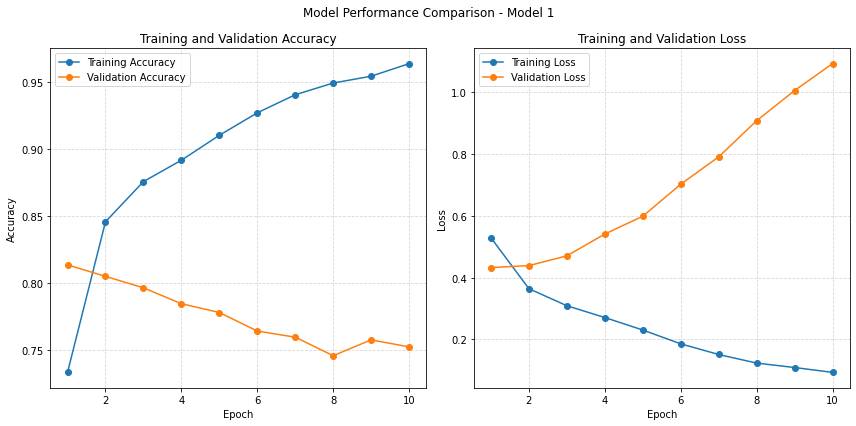

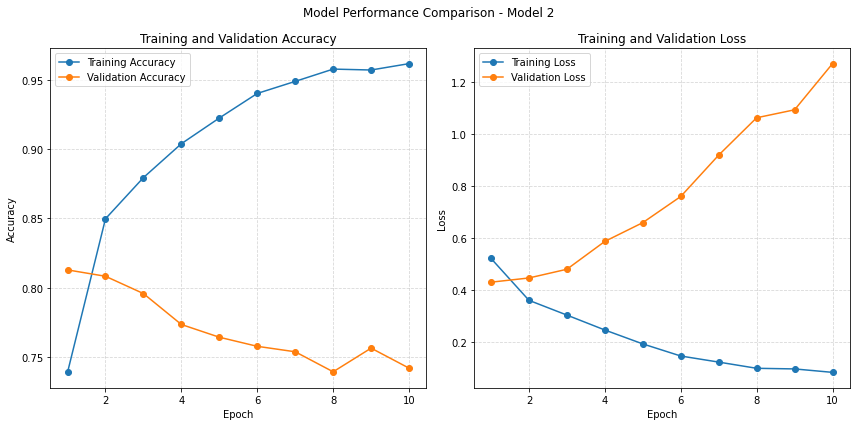

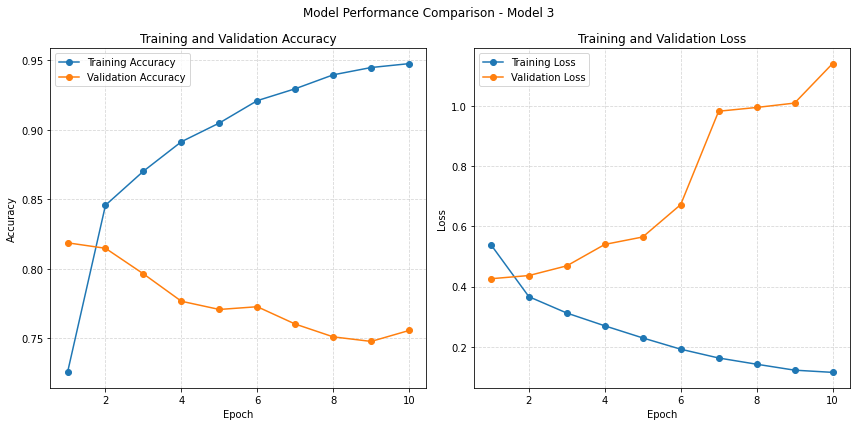

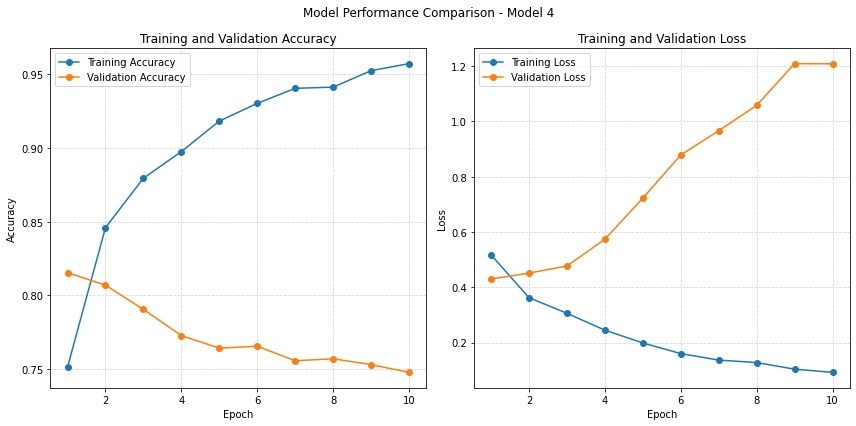

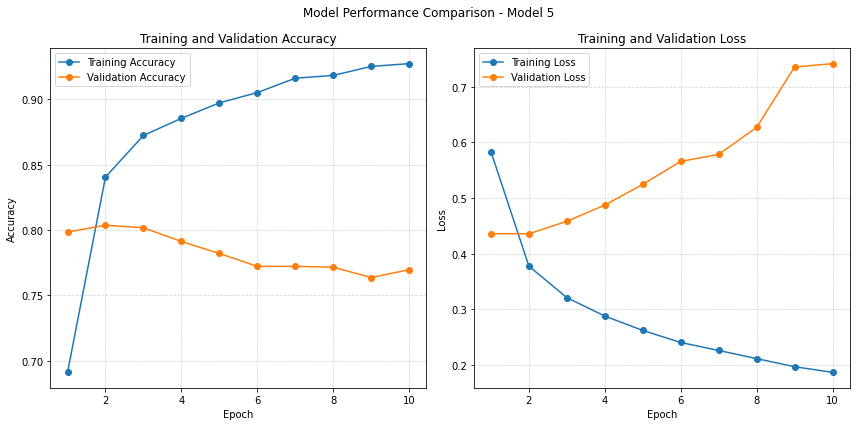

In [106]:
plot_history(history_list[0], 'Model 1')
plot_history(history_list[1], 'Model 2')
plot_history(history_list[2], 'Model 3')
plot_history(history_list[3], 'Model 4')
plot_history(history_list[4], 'Model 5')

In [103]:
for i in pred_list:
    print(classification_report(y_test, i))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       867
           1       0.72      0.69      0.70       656

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.75      0.75      1523

              precision    recall  f1-score   support

           0       0.79      0.74      0.77       867
           1       0.69      0.74      0.71       656

    accuracy                           0.74      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.74      0.74      1523

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       867
           1       0.71      0.73      0.72       656

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

              preci

In [104]:
def plot_cm(pred, modelnum):
    cm = confusion_matrix(y_test, pred)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = ['0', '1'], yticklabels = ['0', '1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Model ' + str(modelnum))
    plt.show()

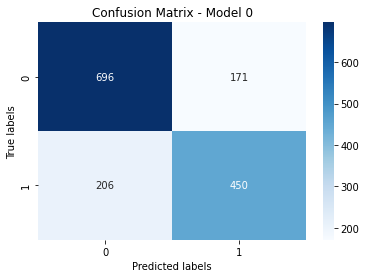

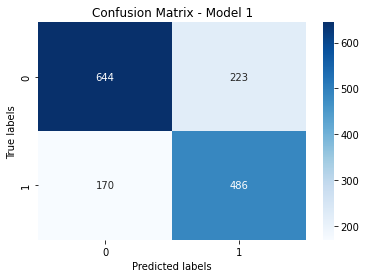

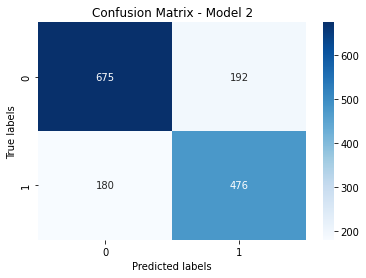

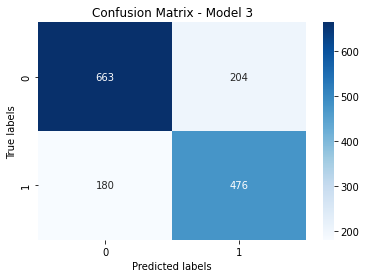

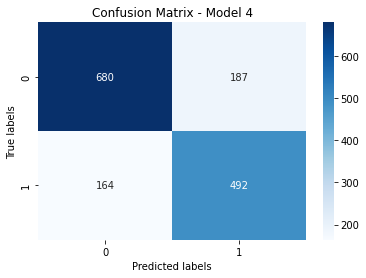

In [105]:
for i in range(len(pred_list)):
    plot_cm(pred_list[i], i)

# Conclusion

Each of the models performed roughly the same, achieving 75% accuracy. Varying the parameters seemed to have little effect, with the exception of the learning rate and the size of the embedded layer. Changing the learning rate to a lower value made the model converge more slowly, as one would expect, but it still behaved similar to the other models after about the fifth epoch. Changing the size of the embedded layer to be larger seemed to result in more over fitting, with a bigger gap between the training accuracy and the validation accuracy. 

Given these results, it appears that merely tweaking the parameters is not sufficient to achieve high accuracies with this model. Instead, a more thorough reworking of the architecture may be in order. It might also be the case that, due to the fluid nature of language, achieving high accuracy in this task is more difficult than it would be in other, more objective tasks. 

https://github.com/obbrown1/Deep-Learning-Week-4

# Submission

In [119]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [120]:
test_data['clean_text'] = test_data['text'].apply(clean_text)
test_data.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills China Taiwan


In [121]:
l =50
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(test_data['clean_text'].values)
X = tokenizer.texts_to_sequences(test_data['clean_text'].values)
X = pad_sequences(X, maxlen =l)

In [122]:
y_pred = model5.predict(X).round()

In [123]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_pred).astype('int')
submission.to_csv('submission.csv', index=False)

# References

https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm

https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4